In [12]:
from keras.layers import Dense,Input
from keras.layers import Conv2D,Flatten
from keras.layers import Reshape,Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

(X_train,_),(X_test,_) = mnist.load_data()
image_size = X_train.shape[1]
X_train = np.reshape(X_train,[-1,image_size,image_size,1])
X_test = np.reshape(X_test,[-1,image_size,image_size,1])
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [13]:
input_shape =(image_size,image_size,1)
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [32,64]
inputs = Input(shape=input_shape,name='encoder_input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters,kernel_size=kernel_size,activation='relu',strides=2,padding='same')(x)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


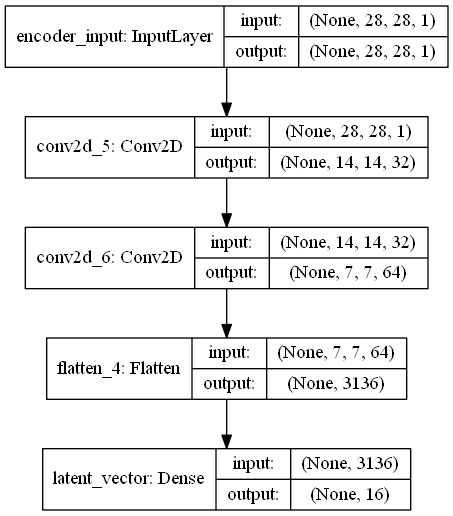

In [14]:
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim,name='latent_vector')(x)
encoder = Model(inputs,latent,name='encoder')
encoder.summary()
plot_model(encoder,to_file='encoder.png',show_shapes=True)

In [17]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,kernel_size=kernel_size,activation='relu',strides=2,padding='same')(x)
outputs = Conv2DTranspose(filters=1,kernel_size=kernel_size,activation='sigmoid',padding='same',name='decoder_output')(x)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_7 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

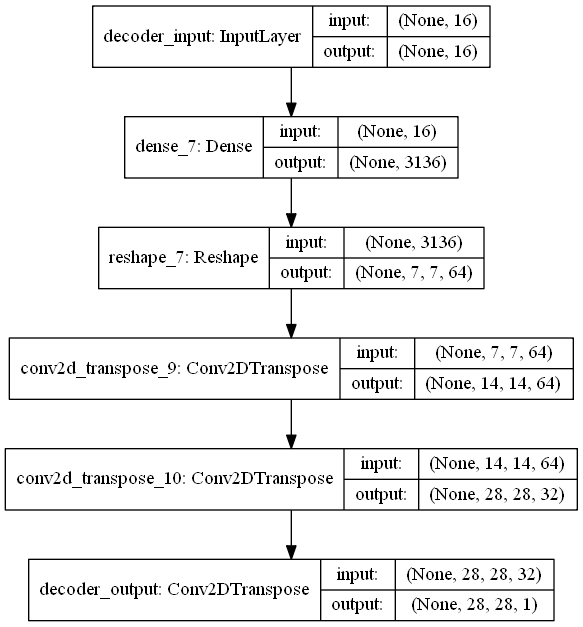

In [19]:
decoder = Model(latent_inputs,outputs,name='decoder')
decoder.summary()
plot_model(decoder,to_file='decoder.png',show_shapes=True)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


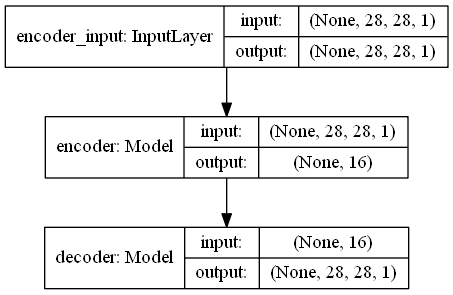

In [22]:
autoencoder = Model(inputs,decoder(encoder(inputs)),name='autoencoder')
autoencoder.summary()
plot_model(autoencoder,to_file='autoencoder.png',show_shapes=True)

In [25]:
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.fit(X_train,X_train,validation_data=(X_test,X_test),epochs=1,batch_size=batch_size)

X_decoded = autoencoder.predict(X_test)
imgs = np.concatenate([X_test[:8], X_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()


Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 3360/60000 [>.............................] - ETA: 1:04 - loss: 0.0921